# Test set visualization
This notebook is to visualize prospection performed on test set examples. This assumes a trained prospector model selected by the user (e.g. through model selection).  

In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
from k2 import K2Processor
from evaluation import extract_params, spawn_model

In [4]:
import utils
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import networkx as nx
import os

First, we access the results of the test set.

In [5]:
# test_df = pd.read_csv('/home/k2/K2/src/outputs/k2-test/all_test_results_points.csv', index_col=0)
test_df = pd.read_csv('/dfs/scratch1/gmachi/gcp_backup/k2/k2-test/all_test_results_points.csv', index_col=0)

In [6]:
test_df

,encoder,model,threshold,datum_id,regime,metric,value,method
0,tile2vec,k20_r8_alpha10000000000.000_tau0.00_lamnan.model,0.4,G-test_069,all,msd,10.790123,K2
1,tile2vec,k20_r8_alpha10000000000.000_tau0.00_lamnan.model,0.4,G-test_069,class-1,specificity,0.145015,K2
2,tile2vec,k20_r8_alpha10000000000.000_tau0.00_lamnan.model,0.4,G-test_069,all,specificity,0.145015,K2
3,tile2vec,k20_r8_alpha10000000000.000_tau0.00_lamnan.model,0.4,G-test_069,class-1,precision,0.028604,K2
4,tile2vec,k20_r8_alpha10000000000.000_tau0.00_lamnan.model,0.4,G-test_069,all,precision,0.028604,K2
...,...,...,...,...,...,...,...,...
2479,PLIP,probs_plip,"('>', 0.9839768032484416)",G-test_020,all,dice,0.000000,Probs
2480,PLIP,probs_plip,"('>', 0.9839768032484416)",G-test_020,all,jaccard,0.000000,Probs
2481,PLIP,probs_plip,"('>', 0.9839768032484416)",G-test_020,all,auroc,NaN,Probs
2482,PLIP,probs_plip,"('>', 0.9839768032484416)",G-test_020,all,auprc,NaN,Probs


In [7]:
# filt = test_df[(test_df.encoder == 'PLIP') & (test_df.metric == 'precision') & (test_df.regime == 'class-1')].sort_values('value', ascending=False)
filt = test_df[(test_df.encoder == 'PLIP') & (test_df.metric == 'auprc')].sort_values('value', ascending=False)
filt.head(20)

,encoder,model,threshold,datum_id,regime,metric,value,method
1706,PLIP,k15_r1_alpha0.010_tau2.00_lamnan.model,0.5,G-test_021,all,auprc,0.995558,K2
2130,PLIP,k15_r1_alpha0.010_tau2.00_lamnan.model,0.5,G-test_105,all,auprc,0.993411,K2
518,PLIP,k15_r1_alpha0.010_tau2.00_lamnan.model,0.5,G-test_071,all,auprc,0.973401,K2
2130,PLIP,probs_plip,"('>', 0.8224855501789692)",G-test_105,all,auprc,0.951259,Probs
1514,PLIP,k15_r1_alpha0.010_tau2.00_lamnan.model,0.5,G-test_016,all,auprc,0.939001,K2
1706,PLIP,probs_plip,"('>', 0.8532156289787344)",G-test_021,all,auprc,0.935726,Probs
1782,PLIP,k15_r1_alpha0.010_tau2.00_lamnan.model,0.5,G-test_090,all,auprc,0.927111,K2
1410,PLIP,k15_r1_alpha0.010_tau2.00_lamnan.model,0.5,G-test_026,all,auprc,0.921105,K2
1470,PLIP,k15_r1_alpha0.010_tau2.00_lamnan.model,0.5,G-test_073,all,auprc,0.863314,K2
2418,PLIP,k15_r1_alpha0.010_tau2.00_lamnan.model,0.5,G-test_113,all,auprc,0.849119,K2


<Axes: >

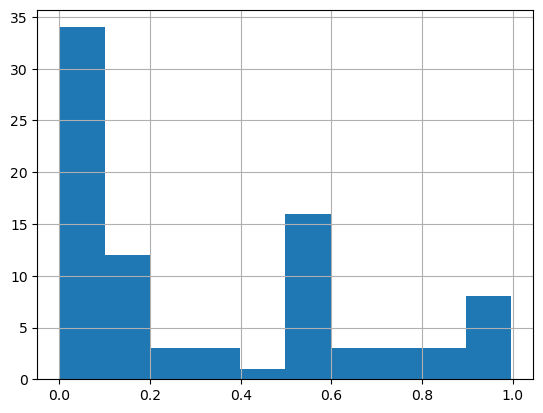

In [8]:
filt.value.hist()

In [7]:
# high_precision = filt[filt.value > 0.5]

In [9]:
encoder = 'plip'

# meta_path = "/home/k2/K2/src/outputs/plip_gridsearch/"
meta_path = "/dfs/scratch1/gmachi/gcp_backup/k2/plip_gridsearch/"
processor_cache_dir = meta_path + encoder + "-fitted_k2_processors"
model_cache_dir = meta_path + encoder + "-fitted_k2_models"

# G_test_dir = "/home/data/tinycam/test/clean_Gs_plip"
# G_train_dir = "/home/data/tinycam/train/clean_Gs_plip"
G_test_dir = "/dfs/scratch1/gmachi/gcp_backup/data/tinycam/test/clean_Gs_plip"
G_train_dir = "/dfs/scratch1/gmachi/gcp_backup/data/tinycam/train/clean_Gs_plip"

model_str = "k15_r1_alpha0.010_tau2.00_lamnan.model" #using the best r>0 model for viz
thresh = 0.5
k,r,alpha,tau,lam = extract_params(model_str)

Here is a helper function to display the test set results

In [10]:
# def create_visualizations(G_id, model_str, processor_cache_dir, model_cache_dir, G_dir, datatype="protein", gt_path=None):
#     if datatype == "protein":
#         k,r,cutoff,alpha,tau,lam = extract_params(model_str)
#         processor_name = "k%d_cutoff%.2f.processor" % (k, cutoff)
#         G_dir = G_dir.replace('cutoff', '%.1f'%cutoff)
#     elif datatype == "image":
#         k,r,alpha,tau,lam = extract_params(model_str)
#         processor_name = "k%d.processor" % (k)

#     proc = utils.deserialize_model(os.path.join(processor_cache_dir, processor_name))
#     model = utils.deserialize_model(os.path.join(model_cache_dir, model_str))

#     if datatype == "protein":
#         G_path = G_dir + "/" + G_id + ".pkl"
#     elif datatype == "image":
#         G_path = G_dir + "/" + G_id 
#     G = utils.deserialize(G_path)
#     sprite = utils.construct_sprite(G, proc)
#     P = model.prospect(G)
#     print('visualizing motif graph...')
#     kernel_map = model.visualize_motif_graph(G)
    
#     if datatype=='protein':
#         print('visualizing sprite...')
#         sprite_viz = utils.visualize_protein_sprite(sprite)
#         print('visualizing prospect map...')
#         prospect_map = utils.visualize_protein_sprite(P, prospect_flag=True)
#         print('visualizing ground truth...')
#         gt = utils.visualize_protein_sprite(utils.set_graph_emb(G, 'gt'), gt_flag=True)
#     elif datatype=="image":
#         sprite_map = utils.convert_graph2arr(sprite)
#         sprite_viz = utils.visualize_quantizedZ(sprite_map)
#         prospect_map = model.visualize_prospect_map(P)
#         gt = utils.deserialize(os.path.join(gt_path, G_id + "-graph"))
#         gt_arr = utils.convert_GTgraph2arr(gt)
#         utils.visualize_GTmap(gt_arr, sprite_map)

#     return kernel_map, sprite_viz, prospect_map, gt

/dfs/scratch1/gmachi/miniconda3/envs/kkenv/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator KMeans from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


No G provided, showing model-wide kernel hash-graph
Displaying motif graph with log2 scaling
[array([0.12156863, 0.46666667, 0.70588235, 1.        ]), array([0.68235294, 0.78039216, 0.90980392, 1.        ]), array([1.        , 0.49803922, 0.05490196, 1.        ]), array([1.        , 0.73333333, 0.47058824, 1.        ]), array([0.17254902, 0.62745098, 0.17254902, 1.        ]), array([0.59607843, 0.8745098 , 0.54117647, 1.        ]), array([0.83921569, 0.15294118, 0.15686275, 1.        ]), array([1.        , 0.59607843, 0.58823529, 1.        ]), array([0.58039216, 0.40392157, 0.74117647, 1.        ]), array([0.77254902, 0.69019608, 0.83529412, 1.        ]), array([0.54901961, 0.3372549 , 0.29411765, 1.        ]), array([0.76862745, 0.61176471, 0.58039216, 1.        ]), array([0.89019608, 0.46666667, 0.76078431, 1.        ]), array([0.96862745, 0.71372549, 0.82352941, 1.        ]), array([0.49803922, 0.49803922, 0.49803922, 1.        ])]


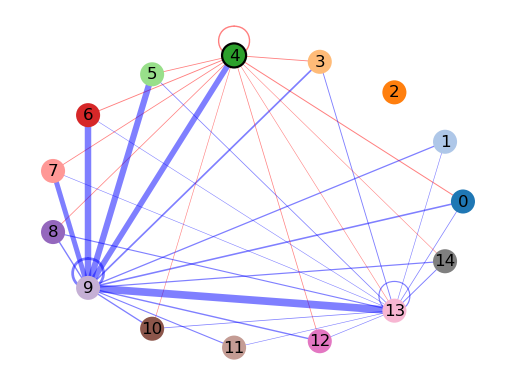

In [11]:
model = utils.deserialize_model(os.path.join(model_cache_dir, model_str))
model.visualize_motif_graph(labels=True)

In [89]:
color_assign = model.color_assignments
color_assign

[array([0.12156863, 0.46666667, 0.70588235, 1.        ]),
 array([0.68235294, 0.78039216, 0.90980392, 1.        ]),
 array([1.        , 0.49803922, 0.05490196, 1.        ]),
 array([1.        , 0.73333333, 0.47058824, 1.        ]),
 array([0.17254902, 0.62745098, 0.17254902, 1.        ]),
 array([0.59607843, 0.8745098 , 0.54117647, 1.        ]),
 array([0.83921569, 0.15294118, 0.15686275, 1.        ]),
 array([1.        , 0.59607843, 0.58823529, 1.        ]),
 array([0.58039216, 0.40392157, 0.74117647, 1.        ]),
 array([0.77254902, 0.69019608, 0.83529412, 1.        ]),
 array([0.54901961, 0.3372549 , 0.29411765, 1.        ]),
 array([0.76862745, 0.61176471, 0.58039216, 1.        ]),
 array([0.89019608, 0.46666667, 0.76078431, 1.        ]),
 array([0.96862745, 0.71372549, 0.82352941, 1.        ]),
 array([0.49803922, 0.49803922, 0.49803922, 1.        ])]

No G provided, showing model-wide kernel hash-graph
Displaying motif graph with log2 scaling


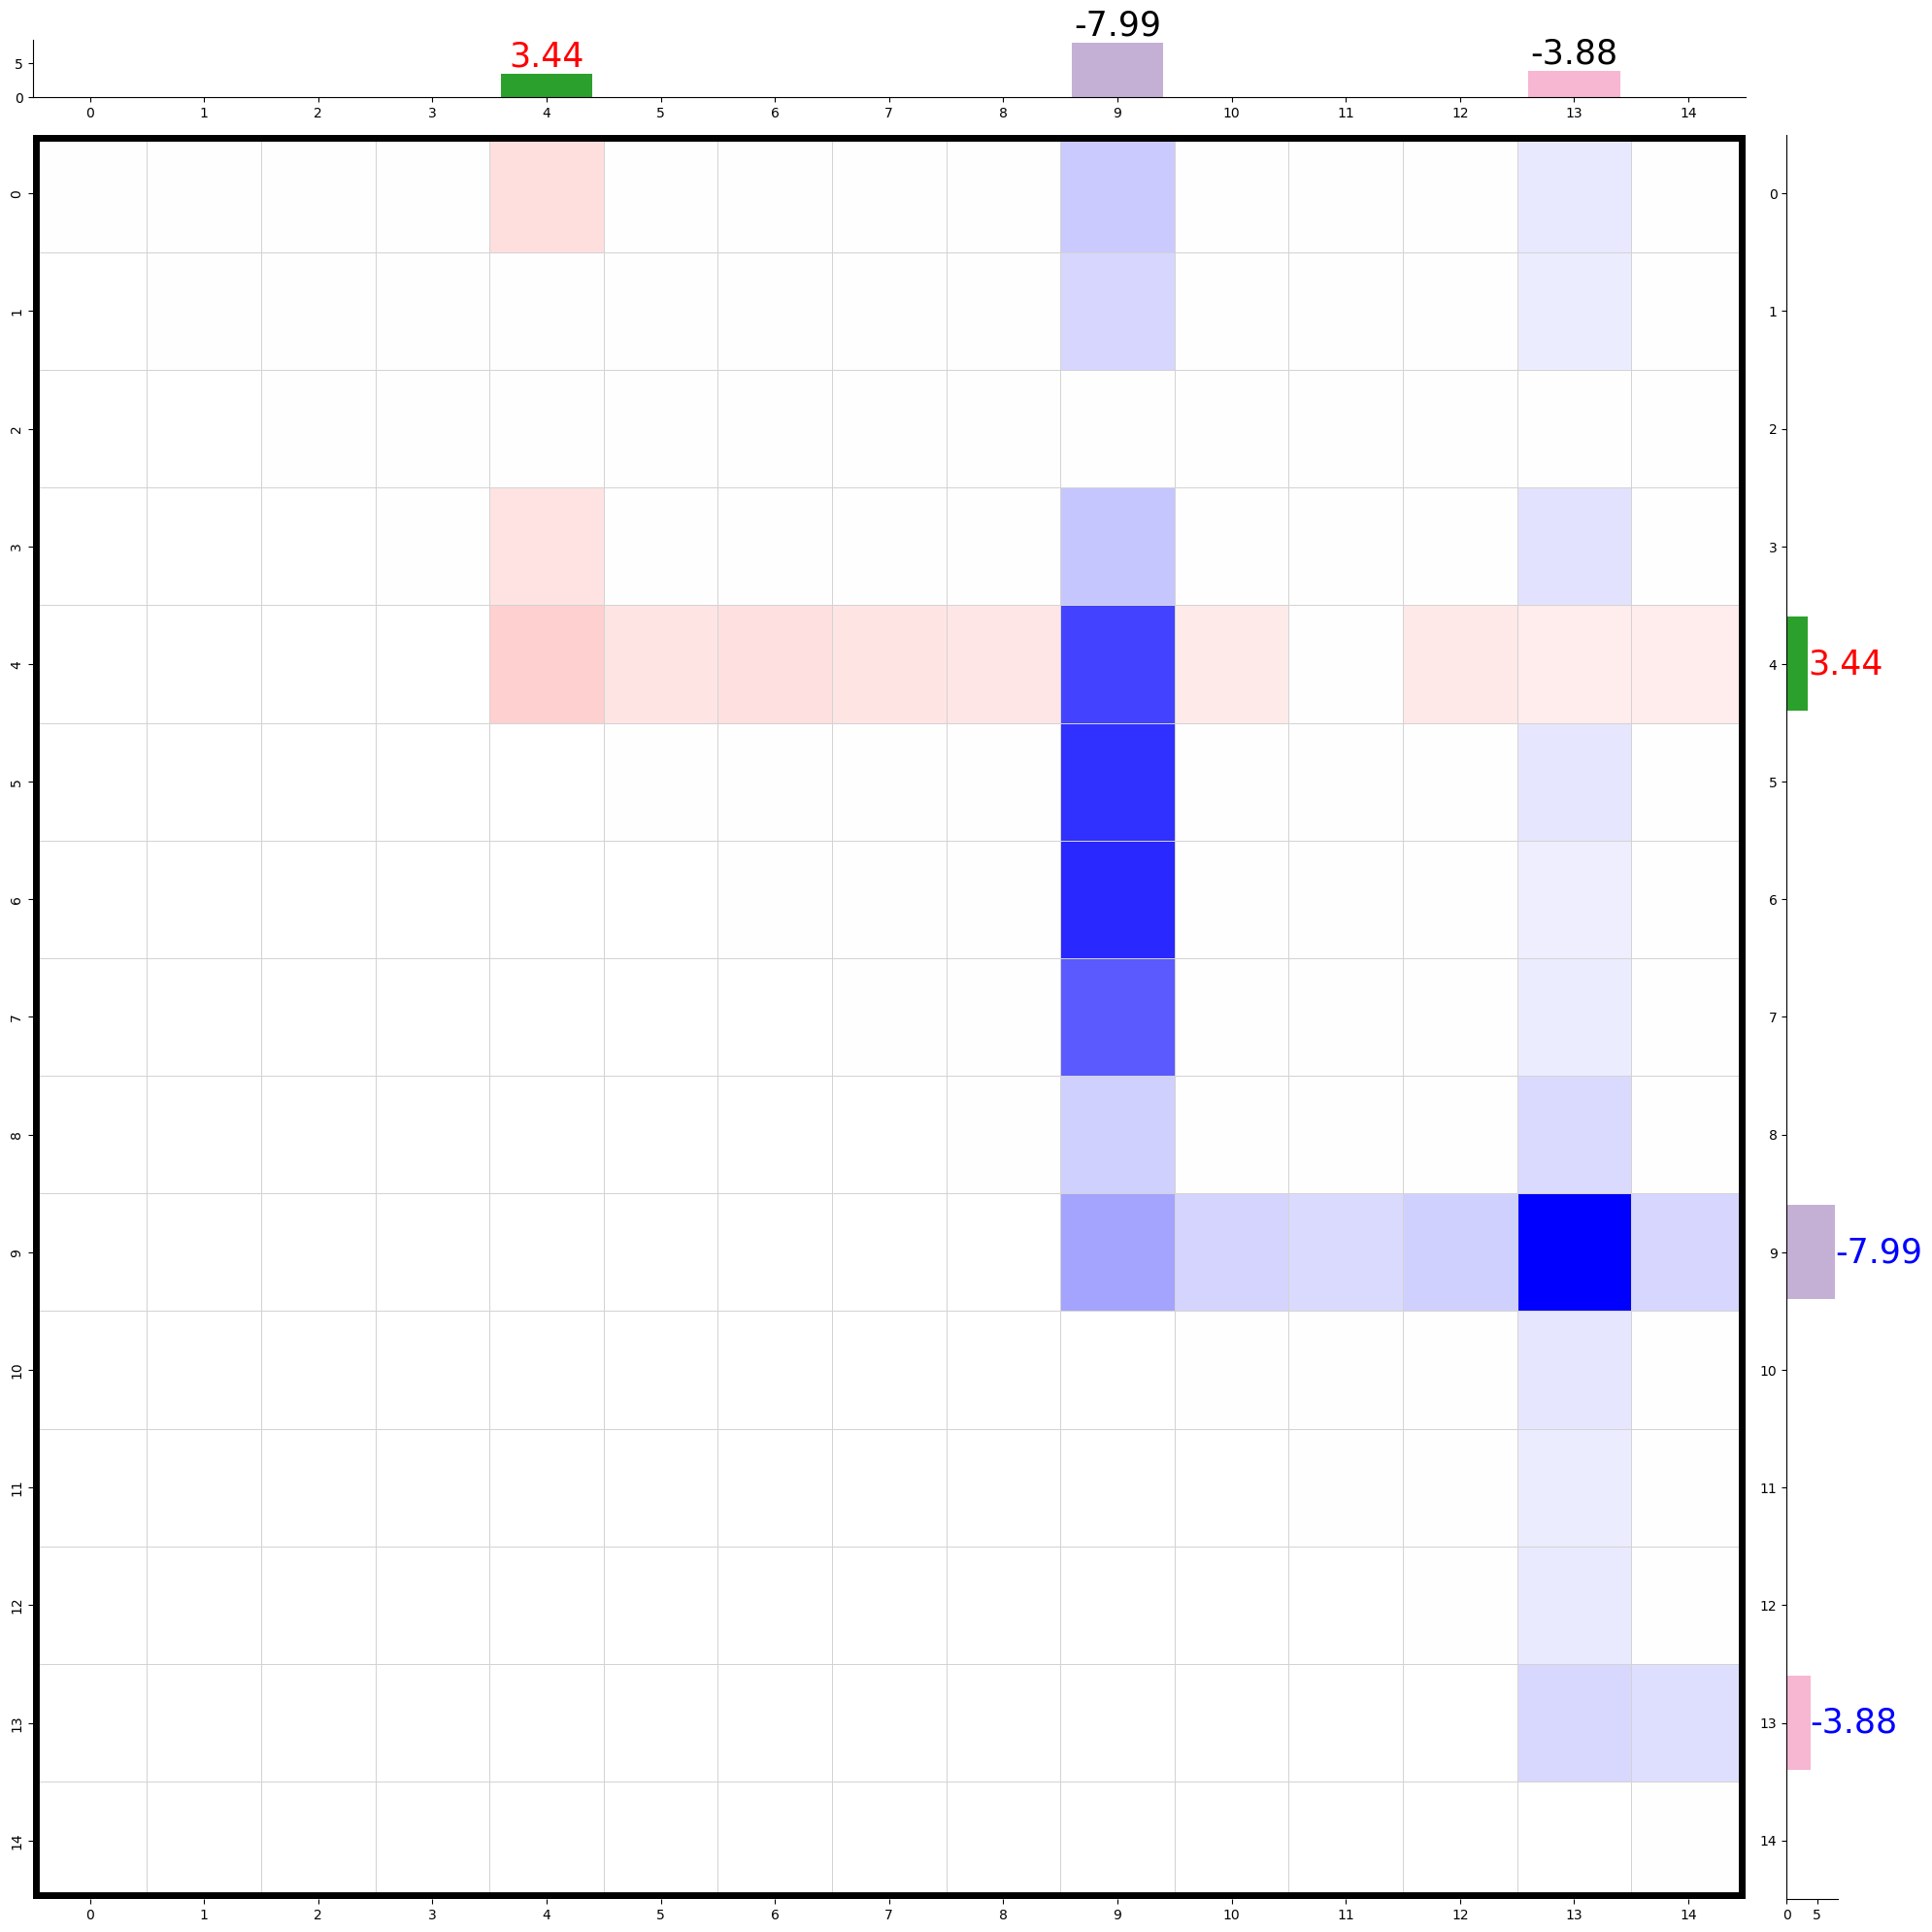

In [12]:
model.visualize_motif_graph(style="matrix", labels=True)

In [95]:
def create_visualizations(G_id, model_str, processor_cache_dir, model_cache_dir, G_dir, datatype="protein", gt_path=None):
    if datatype == "protein":
        k,r,cutoff,alpha,tau,lam = extract_params(model_str)
        processor_name = "k%d_cutoff%.2f.processor" % (k, cutoff)
        G_dir = G_dir.replace('cutoff', '%.1f'%cutoff)
    elif datatype in ['text', "image"]:
        k,r,alpha,tau,lam = extract_params(model_str)
        processor_name = "k%d.processor" % (k)

    proc = utils.deserialize_model(os.path.join(processor_cache_dir, processor_name))
    model = utils.deserialize_model(os.path.join(model_cache_dir, model_str))
    model.visualize_motif_graph(labels=True) # sets color
    color_assign = model.color_assignments

    if datatype == "protein":
        G_path = G_dir + "/" + G_id + ".pkl"
    elif datatype in ["text","image"]:
        G_path = G_dir + "/" + G_id 
    G = utils.deserialize(G_path)
    sprite = utils.construct_sprite(G, proc)
    P = model.prospect(G)
    print('visualizing motif graph...')
    # kernel_map = model.visualize_motif_graph(G)
    kernel_map = model.visualize_motif_graph(G,style="graph",labels=True)
    kernel_map2 = model.visualize_motif_graph(G,style="matrix",labels=True)
    
    if datatype=='protein':
        print('visualizing sprite...')
        sprite_viz = utils.visualize_protein_sprite(sprite)
        print('visualizing prospect map...')
        prospect_map = utils.visualize_protein_sprite(P, prospect_flag=True)
        print('visualizing ground truth...')
        gt = utils.visualize_protein_sprite(utils.set_graph_emb(G, 'gt'), gt_flag=True)
    elif datatype in ['text', "image"]:
        sprite_map = utils.convert_graph2arr(sprite)
        sprite_viz = utils.visualize_quantizedZ(sprite_map, colors=color_assign)
        sprite_graph = utils.visualize_sprite(sprite, color_assign=color_assign)
        prospect_map = model.visualize_prospect_map(P)
        if datatype == "image":
            gt = utils.deserialize(os.path.join(gt_path, G_id + "-graph"))
        elif datatype == "text":
            G_id = G_id.split("_graph")[0] + "_gt.obj"
            gt = utils.deserialize(os.path.join(gt_path, G_id))
        gt_arr = utils.convert_GTgraph2arr(gt)
        utils.visualize_GTmap(gt_arr, sprite_map)

    return kernel_map, sprite_viz, prospect_map, gt

/dfs/scratch1/gmachi/miniconda3/envs/kkenv/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator KMeans from version 1.2.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


No G provided, showing model-wide kernel hash-graph
Displaying motif graph with log2 scaling
[array([0.12156863, 0.46666667, 0.70588235, 1.        ]), array([0.68235294, 0.78039216, 0.90980392, 1.        ]), array([1.        , 0.49803922, 0.05490196, 1.        ]), array([1.        , 0.73333333, 0.47058824, 1.        ]), array([0.17254902, 0.62745098, 0.17254902, 1.        ]), array([0.59607843, 0.8745098 , 0.54117647, 1.        ]), array([0.83921569, 0.15294118, 0.15686275, 1.        ]), array([1.        , 0.59607843, 0.58823529, 1.        ]), array([0.58039216, 0.40392157, 0.74117647, 1.        ]), array([0.77254902, 0.69019608, 0.83529412, 1.        ]), array([0.54901961, 0.3372549 , 0.29411765, 1.        ]), array([0.76862745, 0.61176471, 0.58039216, 1.        ]), array([0.89019608, 0.46666667, 0.76078431, 1.        ]), array([0.96862745, 0.71372549, 0.82352941, 1.        ]), array([0.49803922, 0.49803922, 0.49803922, 1.        ])]
visualizing motif graph...
Displaying motif graph w

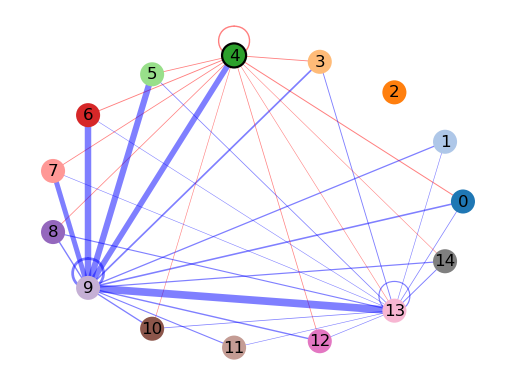

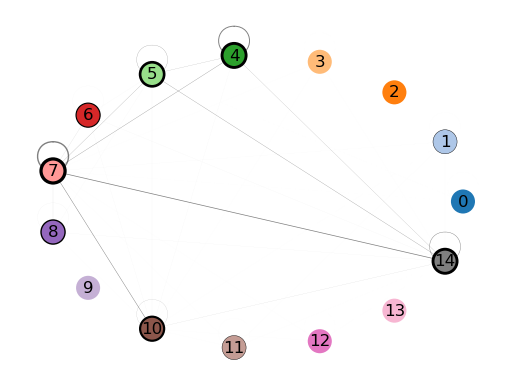

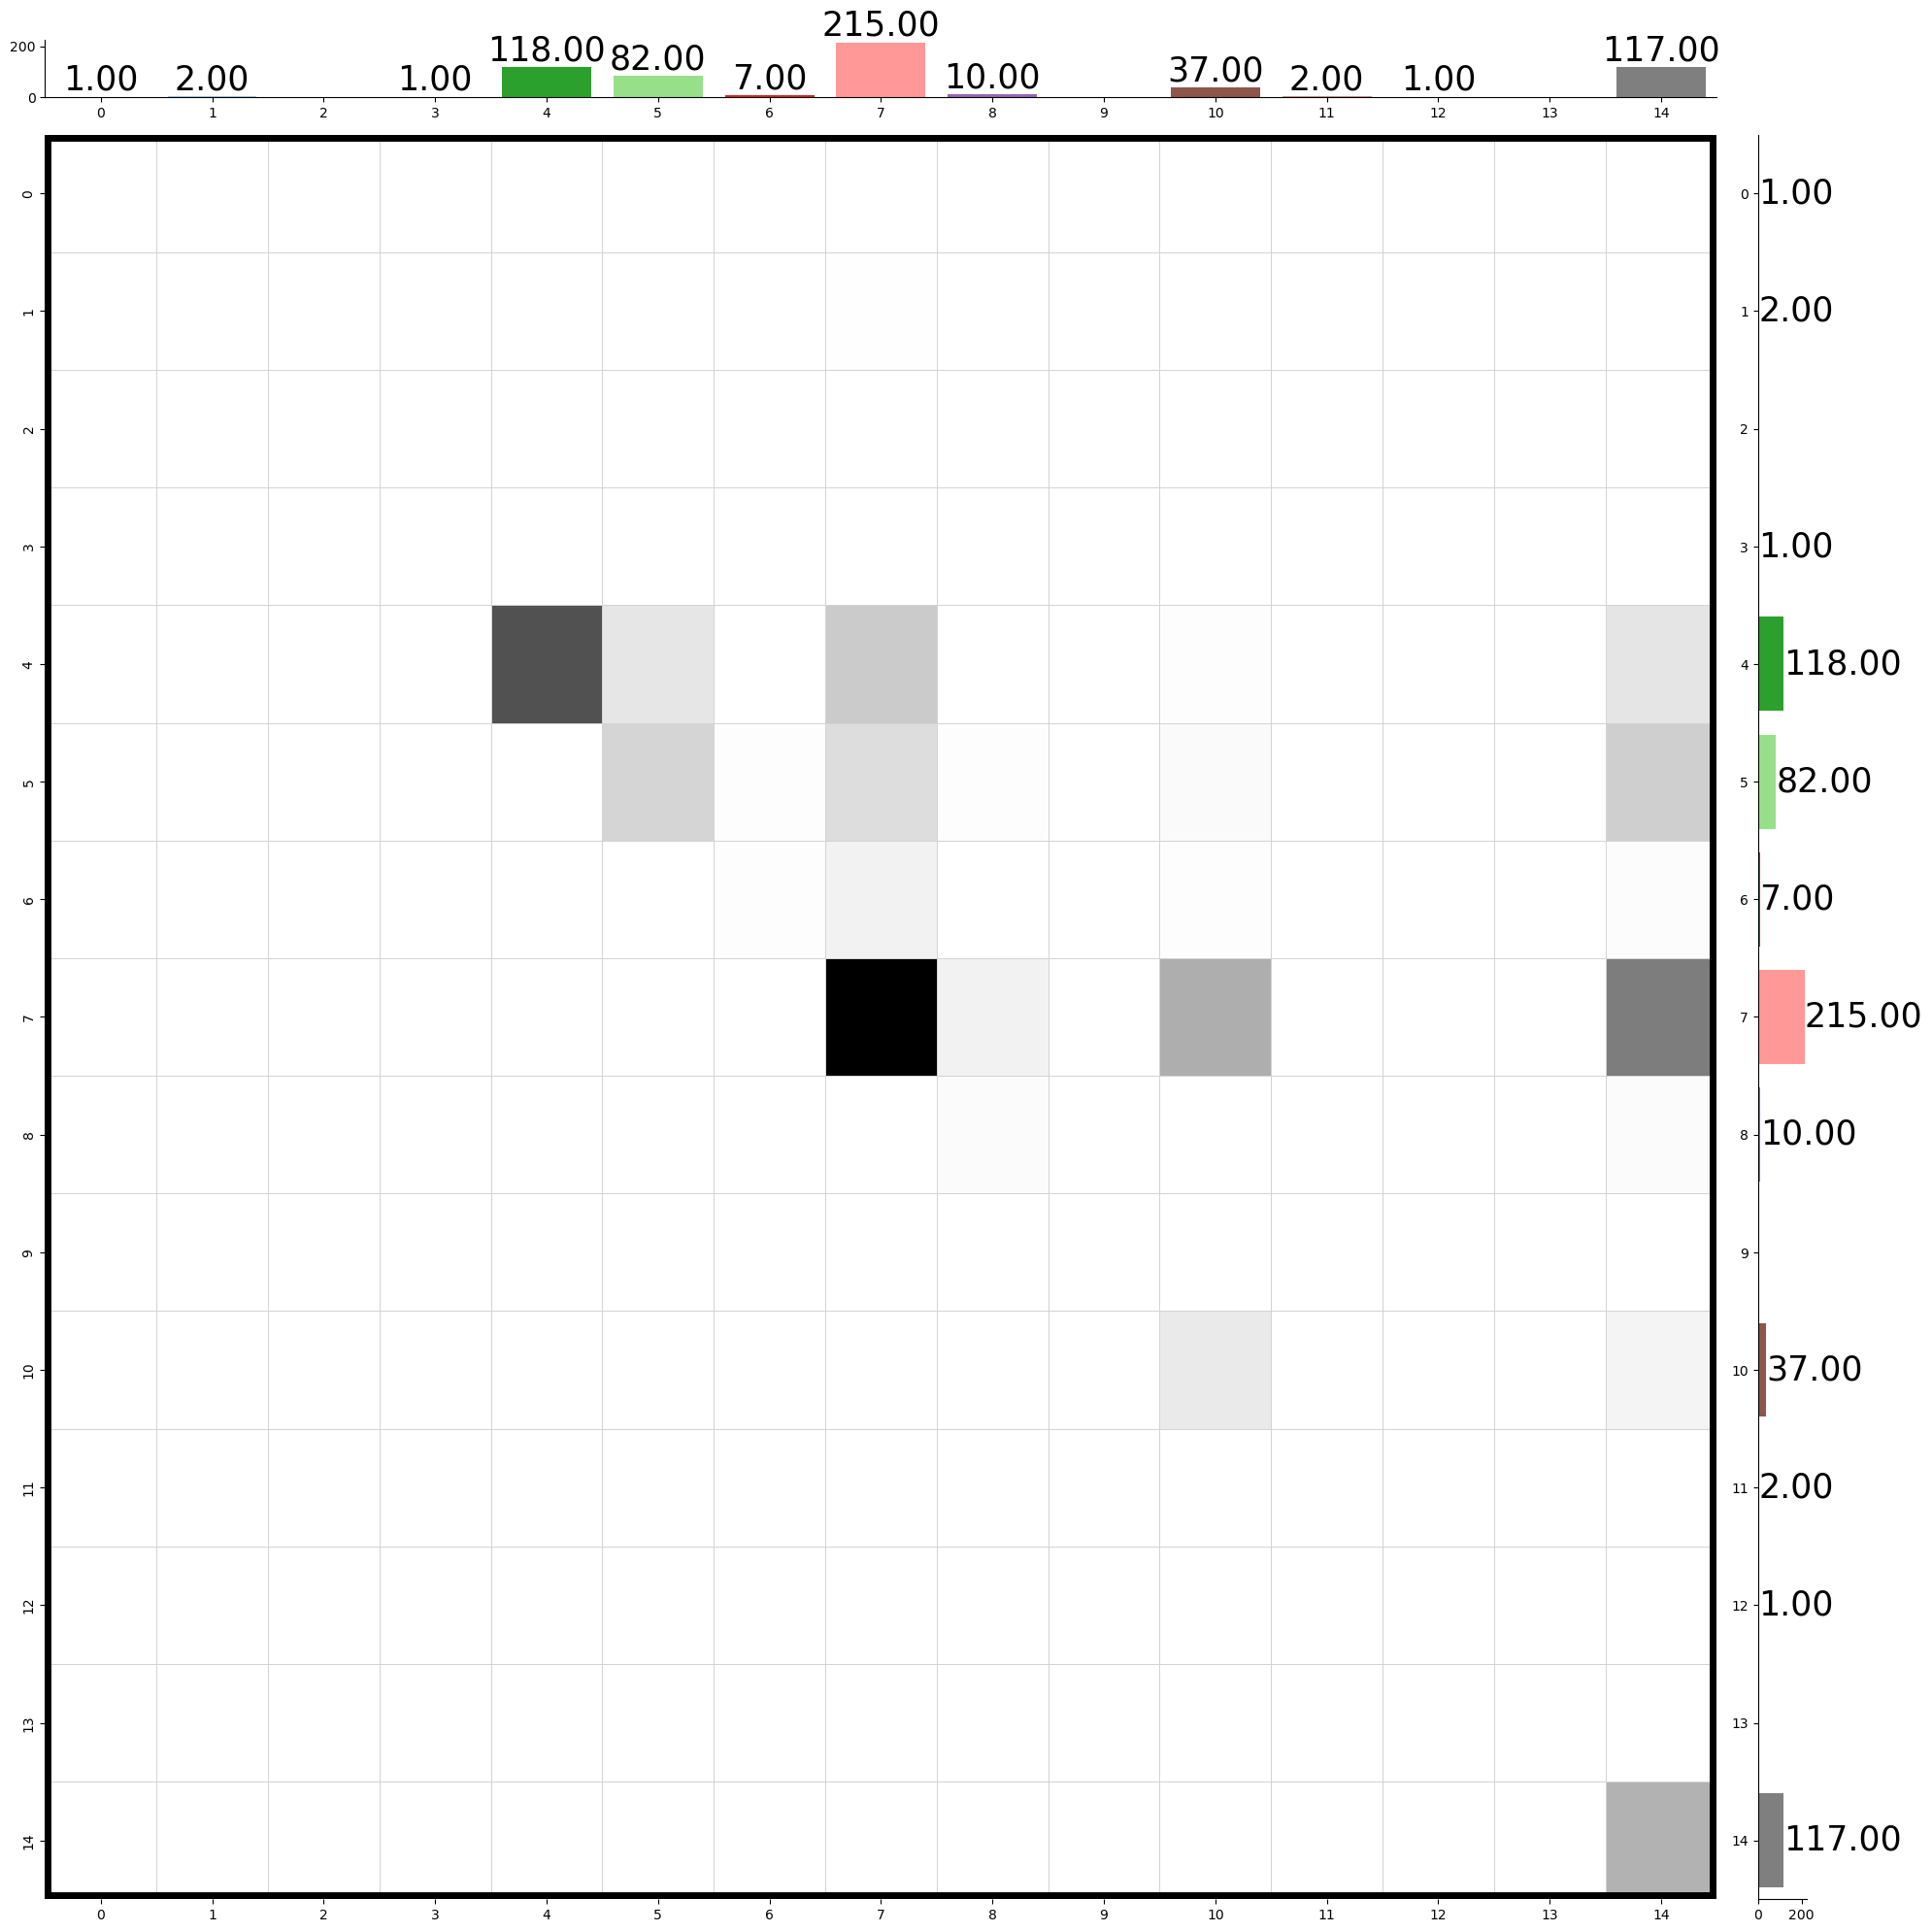

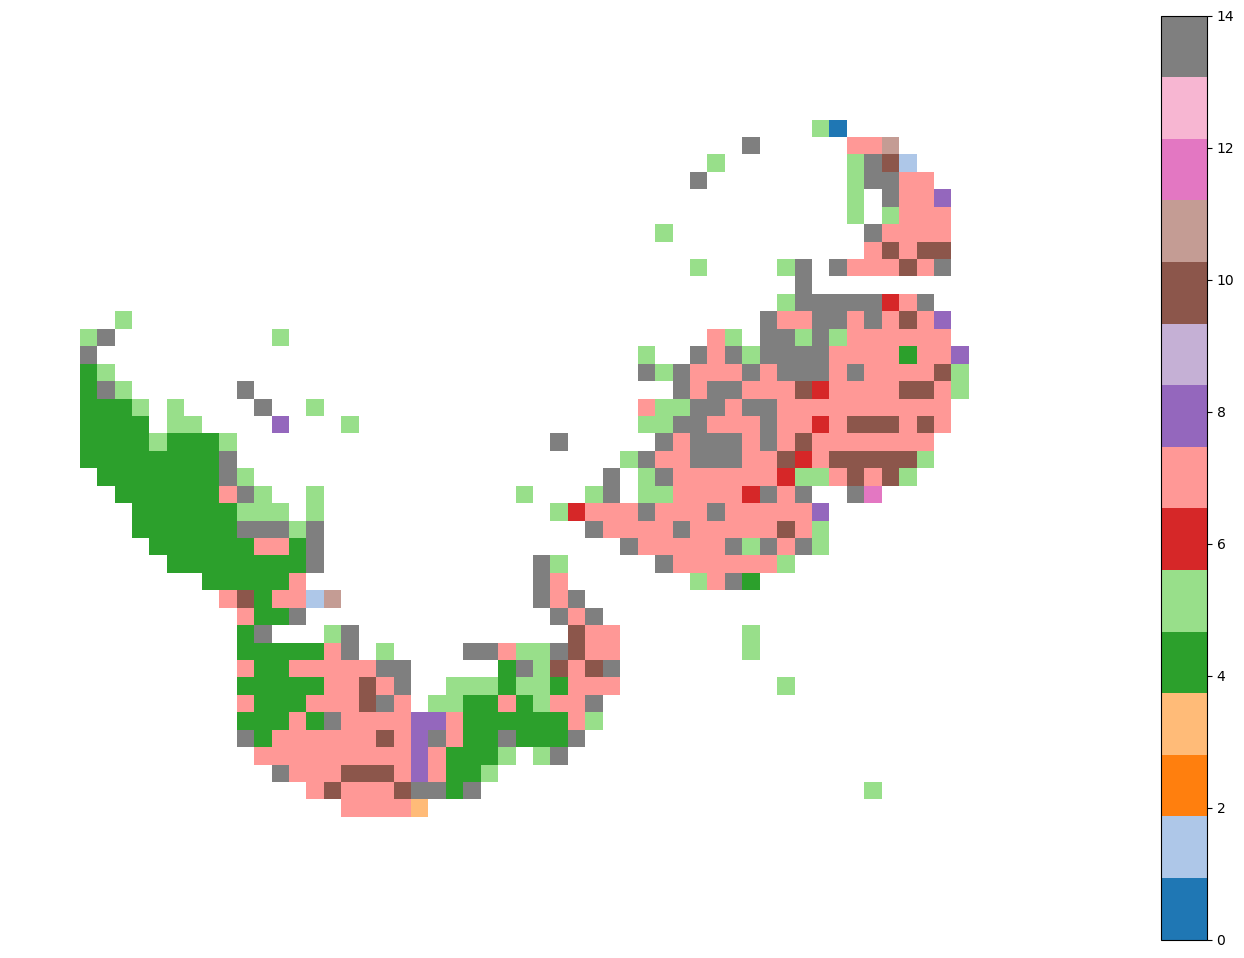

[5, 0, 14, 7, 7, 11, 5, 5, 14, 10, 1, 14, 5, 14, 14, 7, 7, 5, 14, 7, 7, 8, 5, 5, 7, 7, 7, 5, 14, 7, 7, 7, 7, 7, 10, 7, 10, 10, 5, 5, 14, 14, 7, 7, 7, 10, 7, 14, 14, 5, 14, 14, 14, 14, 14, 6, 7, 14, 5, 14, 7, 7, 14, 14, 7, 14, 7, 10, 7, 8, 5, 14, 5, 7, 5, 14, 14, 5, 14, 5, 7, 7, 7, 7, 7, 7, 14, 5, 14, 7, 14, 5, 14, 14, 14, 14, 7, 7, 7, 7, 4, 7, 7, 8, 4, 5, 14, 5, 14, 7, 7, 7, 14, 7, 14, 14, 14, 7, 14, 7, 7, 7, 7, 10, 5, 4, 14, 5, 14, 14, 7, 14, 14, 7, 7, 7, 10, 6, 7, 7, 7, 7, 10, 10, 7, 5, 4, 4, 4, 5, 5, 14, 5, 7, 5, 5, 14, 14, 7, 14, 14, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 4, 4, 4, 4, 5, 5, 8, 5, 5, 5, 14, 14, 7, 7, 7, 14, 7, 7, 6, 7, 10, 10, 10, 7, 10, 7, 4, 4, 4, 4, 5, 4, 4, 4, 5, 14, 14, 7, 14, 14, 14, 7, 14, 7, 10, 7, 7, 7, 7, 7, 7, 7, 4, 4, 4, 4, 4, 4, 4, 4, 14, 5, 14, 7, 7, 14, 14, 14, 7, 7, 10, 6, 7, 10, 10, 10, 10, 10, 5, 4, 4, 4, 4, 4, 4, 4, 14, 5, 14, 5, 14, 7, 7, 7, 7, 7, 7, 6, 5, 5, 7, 10, 7, 10, 5, 4, 4, 4, 4, 4, 4, 7, 14, 5, 5, 5, 5, 14, 5, 5, 7, 7, 7, 7, 6, 14, 7, 14, 14, 12, 

/dfs/scratch1/gmachi/miniconda3/envs/kkenv/lib/python3.10/site-packages/networkx/drawing/nx_pylab.py:433: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


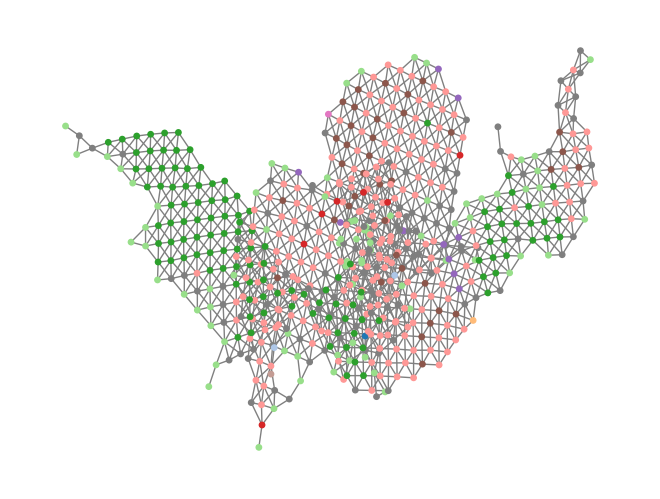

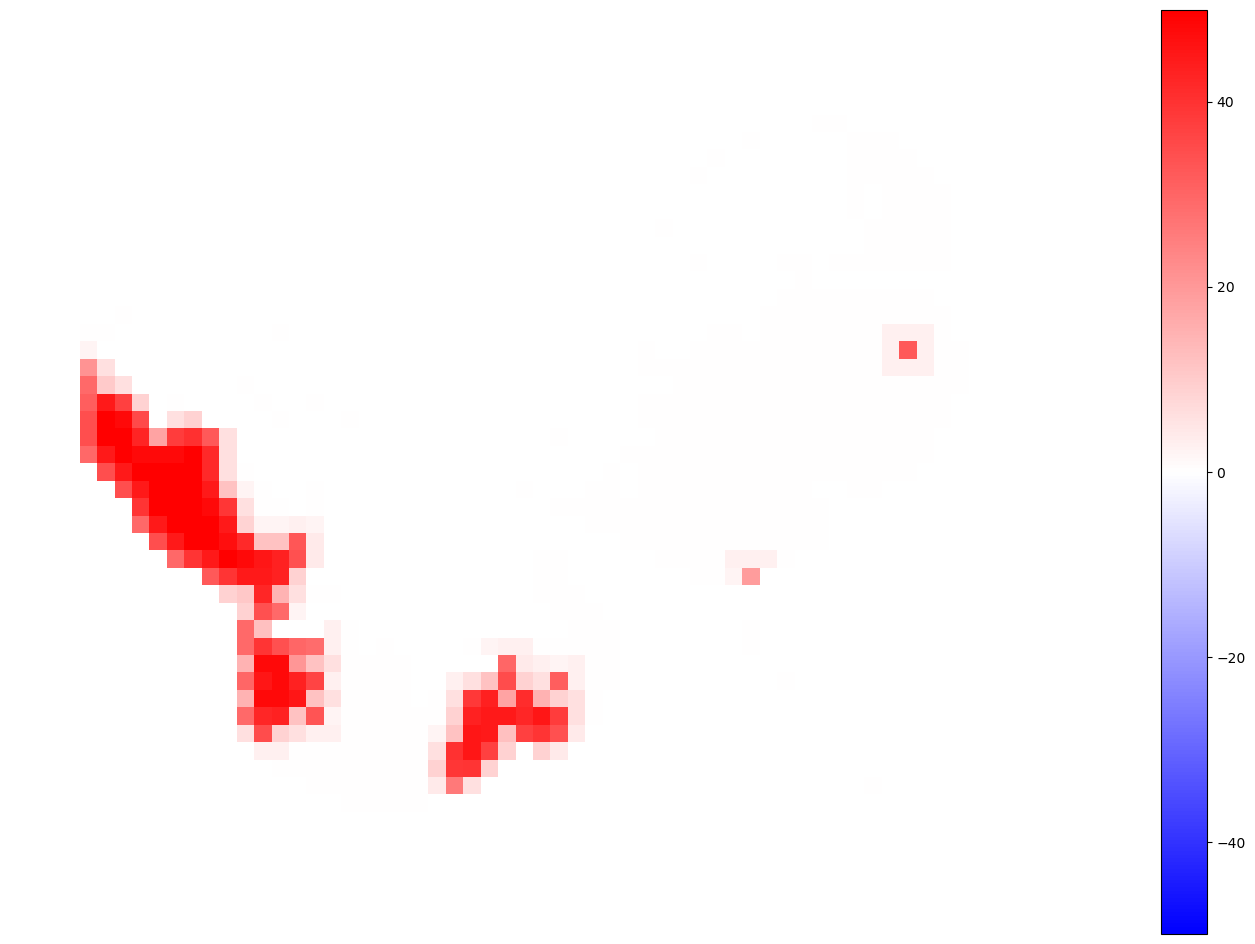

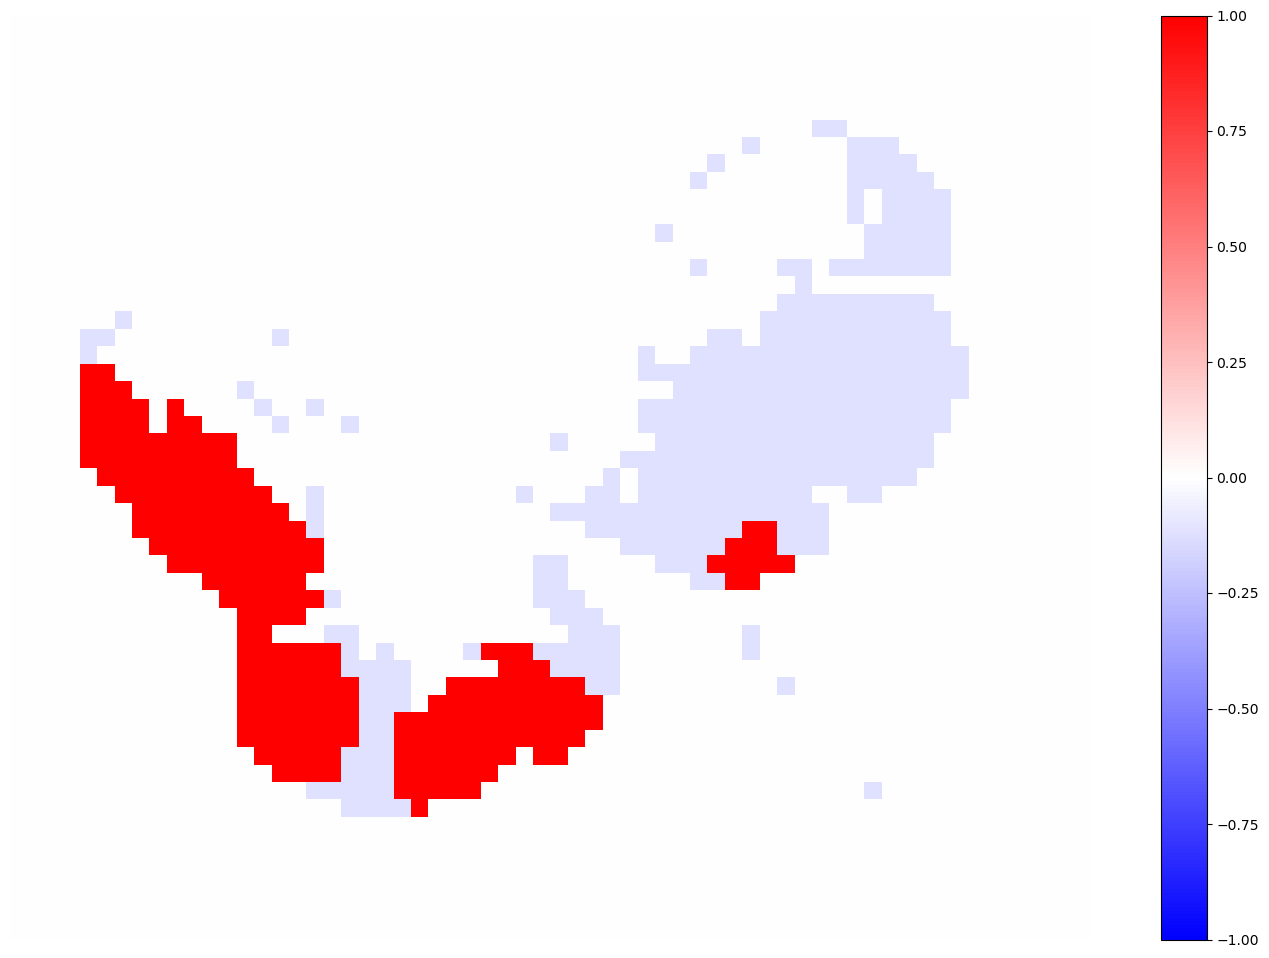

In [226]:
G_id = "G-test_016" #"G-test_001" #"G-test_021" #016, 109, 105, 090, 099. 066,068,069.071,079
# gt_path = "/home/data/tinycam/test/gt_graphs_plip"
gt_path = "/dfs/scratch1/gmachi/gcp_backup/data/tinycam/test/gt_graphs_plip"

kernel_map, sprite_viz, prospect_map, gt = create_visualizations(G_id, model_str, processor_cache_dir, model_cache_dir, G_test_dir, datatype="image", gt_path=gt_path)